In [1]:
!pip install -q pandas
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -q transformers
!pip install -q datasets
!pip install -q git+https://github.com/huggingface/peft.git
!pip install -q bitsandbytes
!pip install -q trl
!pip install -q wandb -U
!pip install -q -U matplotlib

In [2]:
!transformers-cli env


Copy-and-paste the text below in your GitHub issue and FILL OUT the two last points.

- `transformers` version: 4.41.1
- Platform: Windows-10-10.0.22621-SP0
- Python version: 3.11.9
- Huggingface_hub version: 0.23.2
- Safetensors version: 0.4.3
- Accelerate version: 0.30.1
- Accelerate config: 	not found
- PyTorch version (GPU?): 2.3.0+cu121 (True)
- Tensorflow version (GPU?): not installed (NA)
- Flax version (CPU?/GPU?/TPU?): not installed (NA)
- Jax version: not installed
- JaxLib version: not installed
- Using GPU in script?: <fill in>
- Using distributed or parallel set-up in script?: <fill in>



## Prueba del modelo base

In [1]:
import torch
from datasets import load_dataset
from peft import LoraConfig, PeftModel
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
)
from trl import SFTTrainer
from transformers import pipeline

C:\Users\201902452\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Base Model (HuggingFace path)
base_model_id = "meta-llama/Meta-Llama-3-8B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    trust_remote_code=True,
    padding_side="right", # Fix weird overflow issue with fp16 training
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

C:\Users\201902452\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\201902452\.cache\huggingface\hub\models--meta-llama--Meta-Llama-3-8B-Instruct. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Special tokens have been added in the vocabulary, make sure the as

In [3]:
# Parámetros del modelo

# Fine-tunned model name
fine_tuned_model = "MrFat/llama3_8b_medic"

# Dataset name
dataset_name = "harshith99/HealthCareMagic-100k-llama3"

######### QLORA Params #############
# (Para reducir el uso de memoria)

# Estos valores dependen del dataset
# The rank of the low-rank matrix used in the adapters, which thus controls the number of parameters trained. 
# A higher rank will allow for more expressivity, but there is a compute tradeoff. (2^x)
lora_r = 32

# Scaling factor for the learned weights. The weight matrix is scaled by alpha/r, and thus a higher value for alpha assigns more weight to 
# the LoRA activations.
lora_alpha = 64

# NOTA: En el paper de QLoRA utiliza los valoes de r = 64 y alpha = 16, argumentando que estos valores generalizan bastante bien. Si queremos darle mas
# importancia a la data fine-tuneada aumentamos los valores de alpha y si queremos mejor rendimiento disminuimos R.

# Dropout probability
# Durante el entranmiento, en cada epoch hay un {lora_dropout}% de que las neuronas se desactiven (para que trabaje mas)
# Applies dropout regularization to the low-rank matrices, preventing them from overfitting to the specific training data.
lora_dropout = 0.05

####### BitsAndBytes param ###########

#Activamos la reducción de precisión a 4-bit
use_4bit = True

# Parámetro para los modelos 4-bit
bnb_4bit_compute_dtype = "bfloat16" #torch.float16 != torch.bfloat16

# Tipo de cuantización (fp4 o nf4)
# nf4 utiliza una distribución normal
bnb_4bit_quant_type = "nf4"

# Nested quantization for 4-bit base models (double quantization)
# Nos proporciona una mayor eficiencia de memoria sin sacrificiar rendimiento. Lo que hace es
# realizar una segunda cuantización de los pesos ya cuantizados para ahorrar 0.4 bits/parametro.
use_nested_quant = True

####### Training Arguments param #########

#Aqui se guardarán las predicciones y los checkpoints
output_dir = "./resultados"

# Número de epochs (Iteraciones por todo el dataset)
num_train_epochs = 1

# Enable fp16/bf16 training (only aviable for A100 or better GPUs)
fp16 = not torch.cuda.is_bf16_supported()
bf16 = torch.cuda.is_bf16_supported()

# Batch size per GPU for train
per_device_train_batch_size = 1

# Batch size per GPU for evaluation
per_device_eval_batch_size = 2

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
# Afectará al tiempo que tardará en entrenarse.
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule (constant a bit better than cosine)
lr_scheduler_type = "constant"

# Number of training steps (overrides num_train_epochs)
# The total number of training steps to perform.
# Cantidad de batches que pasamos por el modelo
# Uso: Inicialmente a muchos steps y comprobamos a partir de que steps el modelo empieza a degradarse. Para evitar hacer muchos entrenamientos
# en la proxima iteración empezamos desde un checkpoint.
max_steps = 100

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 1

###### Parámetros para SFT ########

# Max sequence length
max_seq_length = 512

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Distribuirá los pesos por todas las GPUs disponibles de forma equitativa
# device_map = "auto" o "balanced"

# Distribuye equitativamente el modelo en todas las GPUs excepto la [0], en esta pondrá lo que no quepa en las demás.
# device_map = "balanced_low_0"

# Pondrá todo lo que pueda en la GPU 0 y pasará a la GPU 1 y asi consecutivamente (No usará las ultimas GPUs si no es necesario)
# device_map = "sequential"

# También podemos limitar la memoria máx que queremos ponerle a cada GPU incluso a la CPU
# device_map = infer_auto_device_map(my_model, max_memory={0: "10GiB", 1: "10GiB", "cpu": "30GiB"})

# Nota: Los CUDA kernels toman 1-2GB de memoria dependiendo de la GPU por lo que hay que contar con menos de la que disponemos (para comprobarlo usar torch.ones(1).cuda())
device_map = "auto"

In [4]:
#Load base model

# Load with QLoRA config
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

# https://huggingface.co/docs/transformers/main_classes/quantization

# Con la librería Transformers podemos usar los algoritmos AWQ y GPTQ de cuantización y soporta
# cuantizaciones de 4 y 8 bits. (Se pueden añadir más técnicas con la clase HfQuantizer)
# En este caso cuantizaremos a 4-bit con el tipo NF4
bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

In [5]:
# https://huggingface.co/docs/transformers/model_doc/auto
# https://huggingface.co/transformers/v2.9.1/main_classes/model.html

# Utilizamos la arquitectura que viene ya incluida en el modelo
# Instantiate a pretrained pytorch model from a pre-trained model configuration.
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    quantization_config=bnb_config,
    low_cpu_mem_usage = True,
    device_map = device_map
)

# https://huggingface.co/transformers/v2.9.1/main_classes/model.html#transformers.PreTrainedModel.generate
#Use past key values?
base_model.config.use_cache = False  # Nos interesa usar los parametros actualizados, no los viejos (cached)

# Mimic the behaviour of the original model at inference?
base_model.config.pretraining_tp = 1 #1 = disable

print(base_model)

Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.83s/it]


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): Ll

In [6]:
# Prueba del modelo base

#eval_prompt = """Print hello world in python java and c"""

eval_prompt = """ <|start_header_id|>system<|end_header_id|> You are a helpful assistant helping individuals with their medical queries <|eot_id|><|start_header_id|>user<|end_header_id|> This is the question: My 15yo daughter has a fever of 102..she is experiencing cold chills and is achy...we went to the er on wed..flu test negative and they said stomach virus.She hasn t eaten in two days and she has no desire to move...what should I do? She is 5 4 and 140lbs<|eot_id|>"""

# CUDA: Para programar directamente la GPU
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

base_model.eval()
with torch.no_grad():
    print(tokenizer.decode(base_model.generate(**model_input, max_new_tokens=512, pad_token_id=2)[0], skip_special_tokens=True))

C:\Users\201902452\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\llama\modeling_llama.py:649: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


 system You are a helpful assistant helping individuals with their medical queries user This is the question: My 15yo daughter has a fever of 102..she is experiencing cold chills and is achy...we went to the er on wed..flu test negative and they said stomach virus.She hasn t eaten in two days and she has no desire to move...what should I do? She is 5 4 and 140lbsassistant

I'm so sorry to hear that your daughter is not feeling well. Given her symptoms and the ER's diagnosis of a stomach virus, it's possible that she may be experiencing a more complex issue. Here are some steps you can take to help her recover:

1. **Continue to monitor her temperature**: Keep an eye on her temperature and make sure it's not rising or falling rapidly. If it's above 102°F (39°C) for more than 2-3 days, you may want to consult her primary care physician or return to the ER.
2. **Provide plenty of fluids**: Encourage your daughter to drink small amounts of fluids, such as water, clear broth, or electrolyte

## Fine-tunning

In [33]:
# Log in to WandDB
import wandb

!wandb login b0ee138ef7cb51349541df5f648e2172d699101c

run = wandb.init(
    project='llama3-8b-instruct-medic-v0.1',
    job_type="training",
    anonymous="allow"
)

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\201902452\.netrc
wandb: Currently logged in as: mrfat. Use `wandb login --relogin` to force relogin


#### Dataset

### MEDIC DATASET

In [6]:
dataset = load_dataset(dataset_name, split="train")
dataset

Generating train split: 100%|███████████████████████████████████████| 112165/112165 [00:00<00:00, 444480.87 examples/s]


Dataset({
    features: ['text'],
    num_rows: 112165
})

Algunos modelos, especialmente los instruct, requieren de chat templates para funcionar correctamente.

In [8]:
# Importante para evitar que haga generación infinita durante la inferencia (Alpaca prompt)
# EOS_TOKEN = tokenizer.eos_token

#def formatting_func(example):

#    text = (f"### Below is an instruction that describes a task, paired with a patient's description that provides further context. \n"
#            f"### Instruction: {example['instruction']} \n"
#            f"### Patient's description: {example['input']} \n"
#            f"### Answer as a doctor: {example['output']}{eos_token}")

#    return text

Codigo para inferencia con llama3-instruct

In [ ]:
# LLama3-Instruct tiene su propia template
# https://github.com/chujiezheng/chat_templates/blob/main/chat_templates/llama-3-instruct.jinja
# https://huggingface.co/meta-llama/Meta-Llama-3-8B-Instruct/blob/main/tokenizer_config.json#L2053

chat_template = open('llama-3-instruct.jinja').read()
chat_template = chat_template.replace('    ', '').replace('\n', '')
tokenizer.chat_template = chat_template


def dataset_format(example):
    # Format system
    if len(example['system']) > 0:
        message = {"role": "system", "content": example['system']}
        system = tokenizer.apply_chat_template([message], tokenize=False)
    else:
        system = ""
    # Format instruction
    message = {"role": "user", "content": example['question']}
    prompt = tokenizer.apply_chat_template([message], tokenize=False, add_generation_prompt=True)
    # Format chosen answer
    chosen = example['chosen'] + "<|eot_id|>\n"
    # Format rejected answer
    rejected = example['rejected'] + "<|eot_id|>\n"
    return {
        "prompt": system + prompt,
        "chosen": chosen,
        "rejected": rejected,
    }

original_columns = dataset.column_names
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

dataset = dataset.map(
    dataset_format,
    remove_columns=original_columns,
    num_proc= os.cpu_count(),
)

In [7]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

To plot the dataset

In [22]:
# Normal tokenization
def generate_and_tokenize_prompt_test(prompt):
    return tokenizer(prompt['text'])

In [23]:
# Tokenization limited to max_seq_length
def generate_and_tokenize_prompt(prompt):
    result = tokenizer(
        prompt['text'],
        truncation=True,
        max_length=max_seq_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [10]:
dataset = dataset.train_test_split(test_size=0.2)

train_dataset = dataset['train']
eval_dataset = dataset['test']

In [11]:
print(train_dataset)

Dataset({
    features: ['text'],
    num_rows: 89732
})


In [12]:
print(eval_dataset)

Dataset({
    features: ['text'],
    num_rows: 22433
})


In [19]:
tokenized_train_dataset_test = train_dataset.map(generate_and_tokenize_prompt_test)
tokenized_val_dataset_test = eval_dataset.map(generate_and_tokenize_prompt_test)

Map: 100%|██████████████████████████████████████████████████████████████| 22433/22433 [00:15<00:00, 1448.13 examples/s]


112165


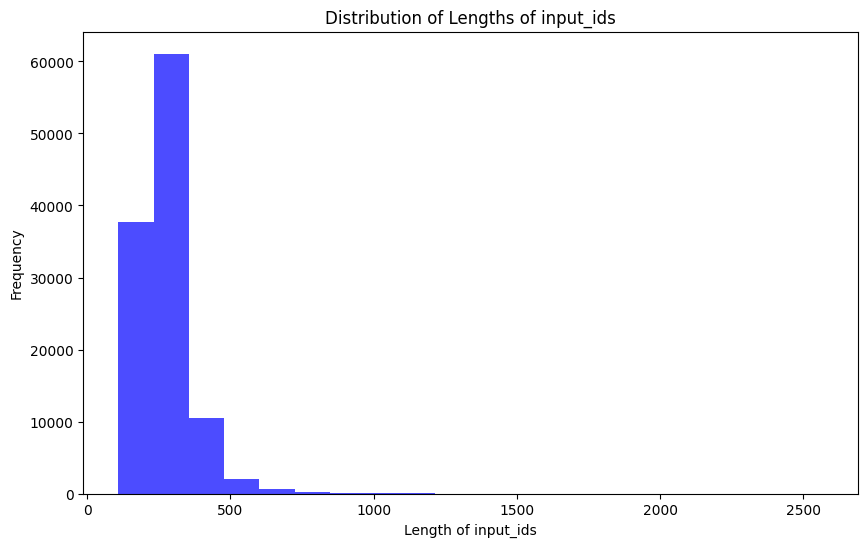

In [20]:
plot_data_lengths(tokenized_train_dataset_test, tokenized_val_dataset_test)

Como la mayoría de los tokens estan por debajo de 500, podemos utilizar un max_seq_length de 512 para asegurarnos de que todos los imputs se tokenizan correctamente. Se observa que la mayoría de las respuestas del dataset estan entorno a los 512 tokens, por lo que podemos escoger un max_seq_length orientado a este valor para que sea más eficiente.

In [24]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map: 100%|██████████████████████████████████████████████████████████████| 22433/22433 [00:18<00:00, 1224.44 examples/s]


In [25]:
print(tokenized_train_dataset)
print(tokenized_val_dataset)

Dataset({
    features: ['text', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 89732
})
Dataset({
    features: ['text', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 22433
})


112165


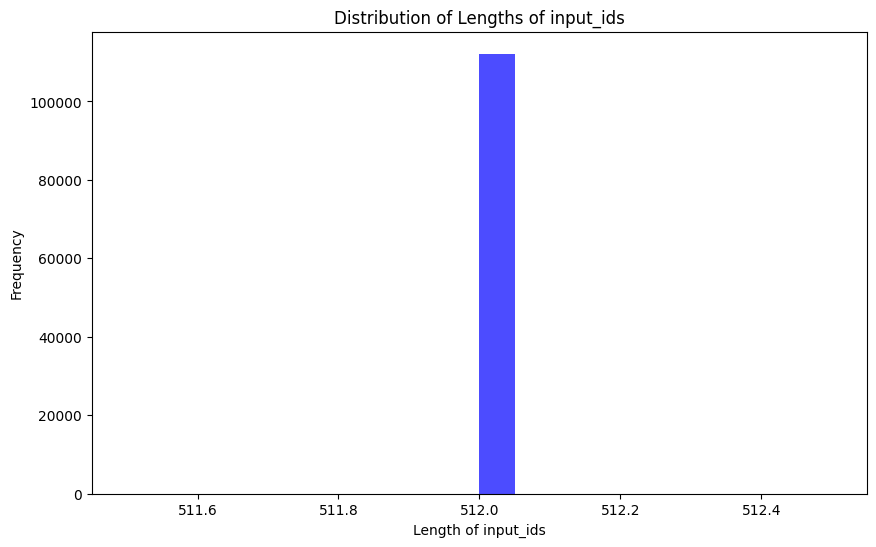

In [26]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

### LORA CONFIG

In [7]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [9]:
print_trainable_parameters(base_model)

trainable params: 1050939392 || all params: 4540600320 || trainable%: 23.145384264959926


In [37]:
# Fine-tunning with QLoRA y Supervised Fine Tunning (SFT)
from peft import get_peft_model

# Set LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    target_modules=[ # From the first print(model)
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none", # Determines how bias terms are handled in LoRA.
    task_type="CAUSAL_LM", # Specifies the type of task the model is being fine-tuned for.
)

# Model with LoRA adapters added
print(get_peft_model(base_model, peft_config))

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj):

In [38]:
# Set training parameters (Loading the trainer)
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="wandb" #Default logging_dir = *output_dir/runs/CURRENT_DATETIME_HOSTNAME*
)

# Initialize the SFTTrainer for fine-tuning
trainer = SFTTrainer(
    model=base_model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,  # Specify the maximum sequence length here
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

C:\Users\201902452\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\utils\_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field, max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
C:\Users\201902452\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
C:\Users\201902452\AppData\Local\Programs\Python\Python311\Lib\site-packages\trl\trainer\sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
C:\Users\201902452\AppData\Local\Programs\Python\Python311\Lib\site-pa

In [39]:
###### START TRAIN ########

# Initialize SFTTrainer (Wandb starts automatically when this is run)
trainer.train()

# Save the fine-tuned model ("Insertar path aqui")
trainer.model.save_pretrained(fine_tuned_model)
tokenizer.save_pretrained(fine_tuned_model)

wandb.finish()

# www.wandb.ai/<your-profile-name>/projects

base_model.config.use_cache = True
base_model.eval()

print(base_model.get_memory_footprint())

###########################

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
C:\Users\201902452\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\llama\modeling_llama.py:649: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Step,Training Loss
1,4.242800
2,3.137800
3,2.392700
4,2.473000
5,3.124700
6,2.783500
7,2.889500
8,2.927000
9,2.595200
10,2.174900


C:\Users\201902452\AppData\Local\Programs\Python\Python311\Lib\site-packages\peft\utils\save_and_load.py:197: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


accuracy,▁
train-loss,▁
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/grad_norm,█▂▃▄▂▁▂▂▁▂▂▂▂▂▄▁▂▂▁▂▁▃▂▂▁▁▂▂▃▃▂▂▂▂▂▂▂▃▁▂
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▃▄▅▄▄▄▆▃▄▂▃▄▃▂▁▂▃▃▃▃▄▃▃▃▃▃▃▃▃▄▃▃▄▄▃▄▄▃▂
accuracy,0.9
total_flos,2332583736115200.0
train-loss,0.5
train/epoch,0.00111


8045912064


In [ ]:
# Como el train y el validation se van reduciendo, podemos afirmar que el modelo esta entrenando

In [74]:
subset_dataset = tokenized_val_dataset.select(range(20))

In [75]:
results = trainer.evaluate(
    eval_dataset=subset_dataset,
    ignore_keys=["text"]
)

print(results)

{'eval_loss': 2.5039196014404297, 'eval_runtime': 81.9141, 'eval_samples_per_second': 0.244, 'eval_steps_per_second': 0.037, 'epoch': 0.0011144296349128516}


In [43]:
prompt = "What is the medical treatment for an infection caused by Baylisascaris?"
pipe = pipeline(task="text-generation", model=base_model, tokenizer=tokenizer, max_length=512)
result = pipe(f"{prompt}")
print(result[0]['generated_text'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


What is the medical treatment for an infection caused by Baylisascaris? Baylisascaris is a type of parasitic worm that infects the digestive system. The medical treatment for an infection caused by Baylisascaris involves the use of an anthelmintic medication, such as albendazole, mebendazole, or praziquantel. These medications are capable of killing the parasite, thereby clearing the infection. In some cases, a combination of medications may be necessary to ensure the elimination of the parasite. In addition to the use of anthelmintic medications, supportive care is also important. This includes the use of an antacid to help alleviate symptoms such as diarrhea and abdominal pain. In some cases, an antibiotic may also be necessary to treat any secondary infections that may be present. It is important for the individual to follow the treatment plan and to take the medication exactly as directed in order to ensure the elimination of the parasite. In addition, it is important for the indiv

In [79]:
# Empty VRAM
del base_model, trainer
torch.cuda.empty_cache()

import gc
gc.collect()

6765

In [2]:
#################################################################
# Tokenizer
#################################################################

model_name_not_merged='C:/Users/201902452/Downloads/MrFat/llama3_8b_medic'

tokenizer_not_merged = AutoTokenizer.from_pretrained(model_name_not_merged, trust_remote_code=True)
tokenizer_not_merged.pad_token = tokenizer_not_merged.eos_token
tokenizer_not_merged.padding_side = "right"

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
#################################################################
# bitsandbytes parameters
#################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "bfloat16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

# Device partition
device_map = "auto"

In [4]:
#################################################################
# Set up quantization config
#################################################################
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

In [5]:
#################################################################
# Load pre-trained config
#################################################################
model_not_merged = AutoModelForCausalLM.from_pretrained(
    model_name_not_merged,
    quantization_config=bnb_config,
    low_cpu_mem_usage = True,
    device_map = "auto"
)

C:\Users\201902452\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.80s/it]


In [7]:
eval_prompt = """I am 57 yrs old and have been taking nebicard sm daily to control my BP. My cholesterol level is 233 and Triglylcerides is 211. I am not taking any other medicines. Kindly let me know if the triglycerides levels go up because of the BP medicine and if so what other medicine can I take as a substitute?"""

# CUDA: Para programar directamente la GPU
model_input = tokenizer_not_merged(eval_prompt, return_tensors="pt").to("cuda")

model_not_merged.eval()
with torch.no_grad():
    print(tokenizer_not_merged.decode(model_not_merged.generate(**model_input, max_new_tokens=512, pad_token_id=2)[0], skip_special_tokens=True))

I am 57 yrs old and have been taking nebicard sm daily to control my BP. My cholesterol level is 233 and Triglylcerides is 211. I am not taking any other medicines. Kindly let me know if the triglycerides levels go up because of the BP medicine and if so what other medicine can I take as a substitute? Thank you.   -   Rajesh Kumar.
 Hi, Thanks for your query. I have gone through your query. Your Triglycerides are high and you are taking Nebicard which is a beta blocker. It can increase Triglycerides. You can consider switching to Nebivolol which is a beta blocker that is less likely to increase Triglycerides. However, you need to consult your doctor for the same. Also, you need to consider changing your diet to a healthy one and also start taking a statin. Hope this helps.   Take Care.   Chat Doctor.  .   .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  

#### Model merging

In [7]:
# Reload the base model
base_model_reload = AutoModelForCausalLM.from_pretrained(
    base_model_id, 
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.bfloat16,
    device_map= "auto")

# load the base model with the PEFT configuration from "fine_tuned_model" directory (MrFat/llama3_8b_medic)
model = PeftModel.from_pretrained(base_model_reload, fine_tuned_model)

# Reload tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model_id, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.48it/s]
C:\Users\201902452\AppData\Local\Programs\Python\Python311\Lib\site-packages\accelerate\utils\modeling.py:1384: UserWarning: Current model requires 8192 bytes of buffer for offloaded layers, which seems does not fit any GPU's remaining memory. If you are experiencing a OOM later, please consider using offload_buffers=True.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [8]:
model = model.merge_and_unload()

In [10]:
model.push_to_hub("MrFat/llama3_8b_medic-v0.3") #Path
tokenizer.push_to_hub("MrFat/llama3_8b_medic-v0.3")

model-00001-of-00007.safetensors:   0%|                                                    | 0.00/4.94G [00:00<?, ?B/s]


Upload 7 LFS files:   0%|                                                                        | 0/7 [00:00<?, ?it/s]
model-00004-of-00007.safetensors:   0%|                                                    | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00007.safetensors:   0%|                                                    | 0.00/5.00G [00:00<?, ?B/s]



model-00003-of-00007.safetensors:   0%|                                                    | 0.00/4.83G [00:00<?, ?B/s]




model-00001-of-00007.safetensors:   0%|                                           | 2.00M/4.94G [00:00<04:34, 18.0MB/s]
model-00004-of-00007.safetensors:   0%|                                           | 3.59M/5.00G [00:00<02:20, 35.7MB/s]

model-00002-of-00007.safetensors:   0%|                                           | 2.38M/5.00G [00:00<03:30, 23.7MB/s]




model-00005-of-00007.safe

CommitInfo(commit_url='https://huggingface.co/MrFat/llama3_8b_medic-v0.3/commit/927596ee543c7fa838e5fa4c7e0cb47caf67dbb5', commit_message='Upload tokenizer', commit_description='', oid='927596ee543c7fa838e5fa4c7e0cb47caf67dbb5', pr_url=None, pr_revision=None, pr_num=None)

In [3]:
################# A PARTIR DE AQUI, EL MODELO YA HA SIDO FINE-TUNEADO ########################

# Inference test

from huggingface_hub import notebook_login
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_id = "MrFat/llama3_8b_medic-v0.3"

bnb_config_hf = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config_hf,
    device_map="auto",
)

To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████| 7/7 [00:11<00:00,  1.58s/it]


In [5]:
tokenizer = AutoTokenizer.from_pretrained(
    model_id,
    trust_remote_code=True,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
messages = [
    {"role": "system", "content": "You are a helpful assistant helping individuals with their medical queries"},
    {"role": "user", "content": "My 15yo daughter has a fever of 102..she is experiencing cold chills and is achy...we went to the er on wed..flu test negative and they said stomach virus.She hasn t eaten in two days and she has no desire to move...what should I do? She is 5 4 and 140lbs"},
]

input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt"
).to(model.device)

terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_flash_sdp(False)
# https://github.com/Lightning-AI/litgpt/issues/327

In [10]:
outputs = model.generate(
    input_ids,
    max_new_tokens=512,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.6,
    top_p=0.9,
)

response = outputs[0][input_ids.shape[-1]:]

print(tokenizer.decode(response, skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


 Hi. Thanks for the query. I have gone through your query in detail. The symptoms mentioned are suggestive of a viral infection, which is common in this age group. Viral infections are self limiting, and the patient usually recovers with time. You can give her some medicines to alleviate the symptoms. The medicines that are commonly used are: 1. Antipyretic - for reducing the temperature. 2. Analgesic - for reducing the pain. 3. Anti-emetic - for reducing the nausea and vomiting. 4. Antihistamine - for reducing the itching and rashes. 5. Throat spray - for soothing the throat. In addition to the medicines, you can also give her a warm bath or a warm drink to help her recover. Hope my answer will help.   Take Care.   Chat Doctor. .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  

In [9]:
eval_prompt =  """<|start_header_id|>system<|end_header_id|> Answer the question truthfully, you are a medical professional.<|eot_id|><|start_header_id|>user<|end_header_id|> This is the question: My 15yo daughter has a fever of 102..she is experiencing cold chills and is achy...we went to the er on wed..flu test negative and they said stomach virus.She hasn t eaten in two days and she has no desire to move...what should I do? She is 5 4 and 140lbs<|eot_id|>"""

# CUDA: Para programar directamente la GPU
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=512, pad_token_id=2)[0], skip_special_tokens=True))

system Answer the question truthfully, you are a medical professional.user This is the question: My 15yo daughter has a fever of 102..she is experiencing cold chills and is achy...we went to the er on wed..flu test negative and they said stomach virus.She hasn t eaten in two days and she has no desire to move...what should I do? She is 5 4 and 140lbsassistant Hello, Thanks for using Chat Doctor. I have gone through your question and can understand your concern. Based on your symptoms, it seems like she is suffering from viral upper respiratory tract infection (URI). Viral URI is caused by viral infection, and the symptoms are self-limiting and resolve by themselves with time. You can give her plenty of fluids like water, ORS, and electrolyte solution to prevent dehydration. Give her an over-the-counter pain reliever like acetaminophen to reduce her body temperature and alleviate her symptoms. In case of severe symptoms, consult your doctor for further evaluation and treatment. Hope I h

In [16]:
messages = [
    {"role": "system", "content": "You are a helpful assistant helping individuals with their medical queries"},
    {"role": "user", "content": "I have chronic kidney disease and have been getting frequent urinary tract infections. I recently had an appendectomy. What antibiotics are safe for me to take, and what should I watch out for to avoid complications?"},
]

input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt"
).to(model.device)

outputs = model.generate(
    input_ids,
    max_new_tokens=512,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.6,
    top_p=0.9,
)

response = outputs[0][input_ids.shape[-1]:]

print(tokenizer.decode(response, skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


 Hi, Thanks for using Chat Doctor. I have gone through your question and can understand your concern. You have chronic kidney disease, which is a chronic condition where kidneys are not functioning properly. In such cases, it is important to avoid infections, which can further deteriorate kidney function. For this, it is important to maintain good hygiene, take nutritious diet, and avoid stress. Also, it is important to take regular medicines, as advised by your doctor. In case of urinary tract infections, it is important to take antibiotics, which are safe for kidneys. In such cases, your doctor may advise you to take antibiotics like ciprofloxacin, cephalexin, or amoxicillin. These are generally safe for kidneys. However, it is important to note that these antibiotics may have side effects like nausea, diarrhea, and stomach pain. So, it is important to take these medicines as advised by your doctor. Also, it is important to avoid taking these medicines for longer period than advised 

In [20]:
# python -m tensorboard.main --logdir=resultados/